In [1]:
!pip install -q segmentation-models-pytorch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)

DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 5
CLASS_NAMES  = ['Urban', 'Vegetation', 'Water', 'Bare Soil', 'Road']
CLASS_COLORS = [[128,128,128],[34,139,34],[65,105,225],[139,90,43],[200,200,100]]
print(f'Device: {DEVICE}')

Device: cpu


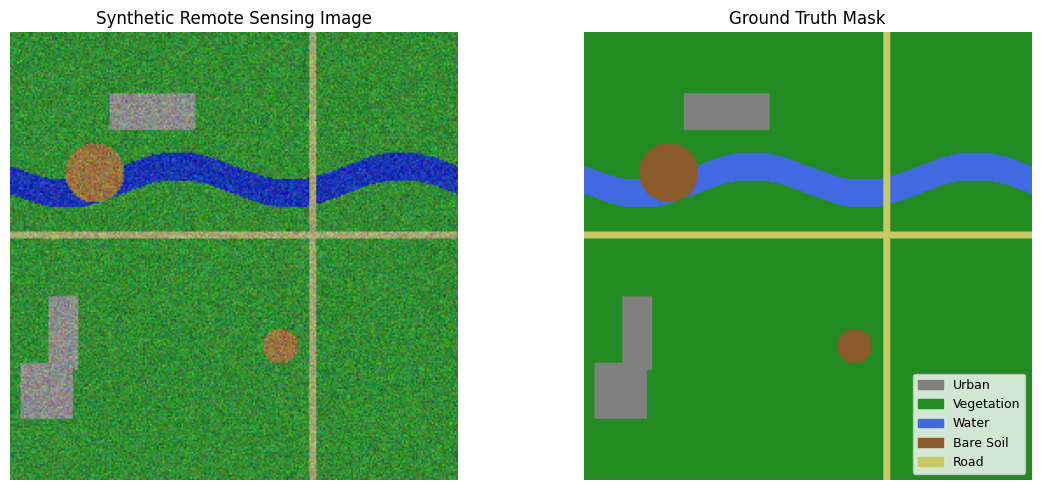

In [3]:
def colorize_mask(mask):
    rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i, c in enumerate(CLASS_COLORS): rgb[mask==i] = c
    return rgb

def generate_sample(img_size=128):
    """Generate synthetic remote sensing image + ground truth segmentation mask."""
    mask = np.ones((img_size, img_size), dtype=np.int64)  # Vegetation base

    # Urban rectangular blocks
    for _ in range(random.randint(3, 7)):
        x1 = random.randint(0, img_size-40)
        y1 = random.randint(0, img_size-40)
        mask[y1:y1+random.randint(15,50), x1:x1+random.randint(15,50)] = 0

    # Meandering river
    cx = (img_size//3 + 8*np.sin(np.linspace(0, 4*np.pi, img_size))).astype(int)
    for i, c in enumerate(cx):
        mask[max(0,c-8):min(img_size,c+8), i] = 2

    # Bare soil elliptical patches
    Y, X = np.ogrid[:img_size, :img_size]
    for _ in range(random.randint(2, 4)):
        cx2 = random.randint(25, img_size-25)
        cy2 = random.randint(25, img_size-25)
        mask[np.sqrt((X-cx2)**2 + (Y-cy2)**2) < random.randint(10,28)] = 3

    # Road cross pattern
    ry = random.randint(img_size//4, 3*img_size//4); mask[ry:ry+4, :] = 4
    rx = random.randint(img_size//4, 3*img_size//4); mask[:, rx:rx+4] = 4

    # Generate image from class spectral signatures
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    means = [[.55,.55,.55], [.2,.55,.2], [.1,.2,.7], [.6,.45,.25], [.65,.65,.45]]
    for ci, m in enumerate(means):
        for c in range(3):
            n = np.random.normal(m[c], 0.08, (img_size, img_size))
            img[:,:,c][mask==ci] = n[mask==ci]
    return np.clip(img, 0, 1), mask

# Visualize
ti, tm = generate_sample(256)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(ti); ax[0].set_title('Synthetic Remote Sensing Image'); ax[0].axis('off')
ax[1].imshow(colorize_mask(tm)); ax[1].set_title('Ground Truth Mask'); ax[1].axis('off')
patches = [mpatches.Patch(color=np.array(c)/255, label=n) for c,n in zip(CLASS_COLORS, CLASS_NAMES)]
ax[1].legend(handles=patches, loc='lower right', fontsize=9)
plt.tight_layout(); plt.show()

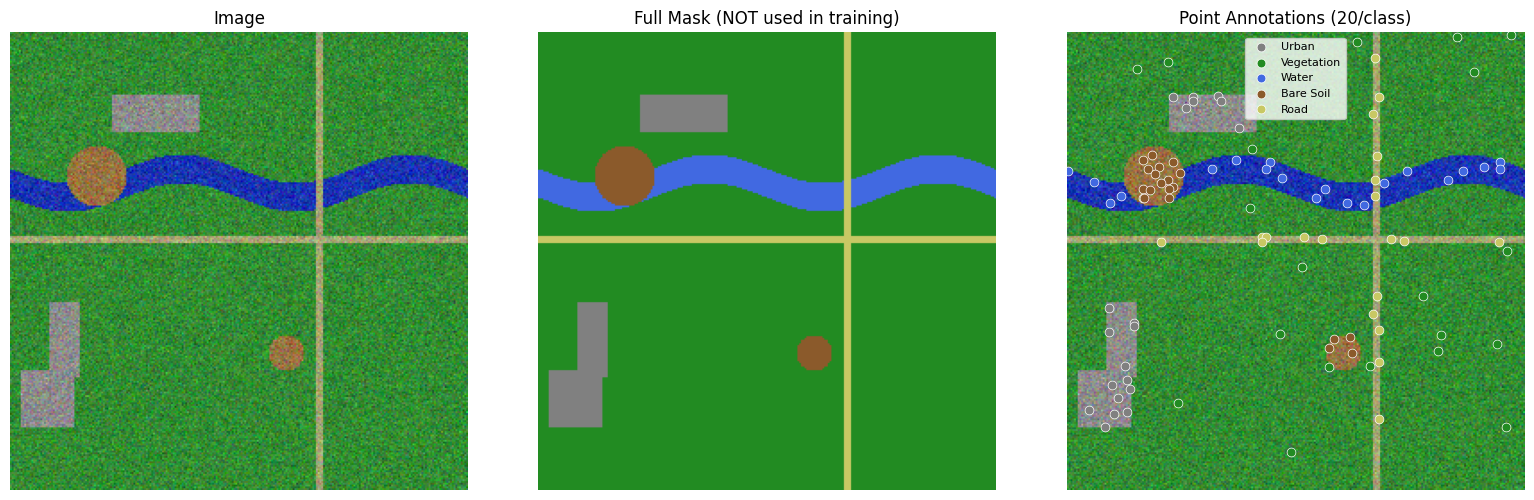

Labeled: 100/65536 (0.15% of all pixels)


In [4]:
def sample_point_labels(mask, n_per_class=10, strategy='random'):
    """
    Simulate sparse point annotation by sampling N pixels per class.
    Returns point_mask: H x W with class label at annotated pixels, -1 elsewhere.
    strategy: 'random' or 'stratified' (spatially spread out)
    """
    pt = np.full(mask.shape, -1, dtype=np.int64)
    for cls in range(NUM_CLASSES):
        coords = np.argwhere(mask == cls)
        if len(coords) == 0: continue
        n = min(n_per_class, len(coords))
        if strategy == 'random':
            ch = coords[np.random.choice(len(coords), n, replace=False)]
        else:  # stratified
            s = coords.copy(); np.random.shuffle(s)
            ch = s[np.linspace(0, len(s)-1, n, dtype=int)]
        for r, c in ch: pt[r, c] = cls
    return pt

# Visualize
tpt = sample_point_labels(tm, 20)
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].imshow(ti); ax[0].set_title('Image'); ax[0].axis('off')
ax[1].imshow(colorize_mask(tm)); ax[1].set_title('Full Mask (NOT used in training)'); ax[1].axis('off')
ax[2].imshow(ti)
for cls in range(NUM_CLASSES):
    pts = np.argwhere(tpt == cls)
    if len(pts):
        ax[2].scatter(pts[:,1], pts[:,0], c=[np.array(CLASS_COLORS[cls])/255],
                      s=40, zorder=5, edgecolors='w', lw=0.5, label=CLASS_NAMES[cls])
ax[2].set_title('Point Annotations (20/class)'); ax[2].legend(fontsize=8); ax[2].axis('off')
plt.tight_layout(); plt.show()
lab = (tpt >= 0).sum()
print(f'Labeled: {lab}/{tpt.size} ({100*lab/tpt.size:.2f}% of all pixels)')

In [5]:
class PartialCrossEntropyLoss(nn.Module):
    """
    Partial Cross-Entropy Loss for point-supervised segmentation.

    Computes cross-entropy ONLY at annotated pixel locations.
    All unlabeled pixels (label == -1) are masked out and contribute ZERO loss.

    Formula:
        pCE = sum( CE(pred_i, gt_i) * MASK_i ) / sum(MASK_i)
        where MASK_i = 1 if pixel i is annotated, else 0
    """
    def __init__(self, ignore_index=-1):
        super().__init__()
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        """
        logits  (Tensor): (B, C, H, W) — raw model predictions
        targets (Tensor): (B, H, W)    — class labels; -1 = unlabeled
        Returns: Scalar loss averaged over annotated pixels only
        """
        # MASK_point: 1 at annotated locations, 0 elsewhere
        mask = (targets != self.ignore_index).float()     # (B, H, W)

        # Replace -1 with 0 temporarily (masked pixels won't affect result)
        t_safe = targets.clone()
        t_safe[targets == self.ignore_index] = 0

        # Per-pixel cross-entropy without reduction
        ce = F.cross_entropy(logits, t_safe, reduction='none')   # (B, H, W)

        # Zero out unlabeled pixels and normalize
        n = mask.sum()
        if n == 0:
            return torch.tensor(0.0, requires_grad=True, device=logits.device)
        return (ce * mask).sum() / n


# ---- Unit Test ----
pce = PartialCrossEntropyLoss()
B, C, H, W = 2, NUM_CLASSES, 64, 64
logits   = torch.randn(B, C, H, W, requires_grad=True)
full_t   = torch.randint(0, C, (B, H, W))
point_t  = full_t.clone(); point_t[torch.rand(B,H,W) > 0.05] = -1
empty_t  = torch.full((B, H, W), -1, dtype=torch.long)

print(f'Full CE loss    (100% labeled): {F.cross_entropy(logits, full_t).item():.4f}')
print(f'Partial CE loss (~5% labeled): {pce(logits, point_t).item():.4f}')
print(f'Empty mask loss  (0% labeled): {pce(logits, empty_t).item():.4f}  ← should be 0.0')
pce(logits, point_t).backward()
print(f'Gradient norm: {logits.grad.norm():.4f}  ← non-zero confirms correct gradient flow')
print('✓ PartialCrossEntropyLoss verified!')

Full CE loss    (100% labeled): 1.9947
Partial CE loss (~5% labeled): 2.0326
Empty mask loss  (0% labeled): 0.0000  ← should be 0.0
Gradient norm: 0.0495  ← non-zero confirms correct gradient flow
✓ PartialCrossEntropyLoss verified!


In [6]:
class RSDataset(Dataset):
    """
    Remote sensing segmentation dataset with point label simulation.
    full_mask is kept for evaluation ONLY; training uses point_mask exclusively.
    """
    def __init__(self, n=200, sz=128, n_pts=10, strategy='random', aug=False):
        self.aug = aug
        self.norm = transforms.Normalize([.485,.456,.406], [.229,.224,.225])
        self.data = []
        print(f'Generating {n} samples (pts={n_pts}, strategy={strategy})...')
        for _ in tqdm(range(n)):
            img, mask = generate_sample(sz)
            pt = sample_point_labels(mask, n_pts, strategy)
            self.data.append((img, mask, pt))

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img, full, pt = self.data[idx]
        t = self.norm(torch.from_numpy(img).permute(2,0,1).float())
        if self.aug and random.random() > .5:
            t = torch.flip(t, [2])
            full = np.fliplr(full).copy()
            pt   = np.fliplr(pt).copy()
        return t, torch.from_numpy(full).long(), torch.from_numpy(pt).long()

print('Building datasets (10 pts/class, random)...')
train_ds = RSDataset(200, 128, 10, 'random', aug=True)
val_ds   = RSDataset(50, 128, 10, 'random')
test_ds  = RSDataset(50, 128, 10, 'random')
trl = DataLoader(train_ds, 8, shuffle=True,  num_workers=2)
vll = DataLoader(val_ds,   8, shuffle=False, num_workers=2)
tel = DataLoader(test_ds,  8, shuffle=False, num_workers=2)
print(f'Train:{len(trl)} Val:{len(vll)} Test:{len(tel)} batches')

Building datasets (10 pts/class, random)...
Generating 200 samples (pts=10, strategy=random)...


100%|██████████| 200/200 [00:05<00:00, 34.53it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:01<00:00, 32.03it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:01<00:00, 30.32it/s]

Train:25 Val:7 Test:7 batches


In [7]:
def build_model():
    """U-Net with ImageNet-pretrained ResNet34. Transfer learning is critical
    for good performance under sparse point supervision."""
    return smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=NUM_CLASSES,
        activation=None   # raw logits; softmax handled inside loss
    )

m = build_model().to(DEVICE)
print(f'Model: U-Net (ResNet34, ImageNet pretrained)')
print(f'Parameters: {sum(p.numel() for p in m.parameters()):,}')
with torch.no_grad():
    out = m(torch.randn(2, 3, 128, 128).to(DEVICE))
print(f'Output shape: {out.shape} (B,C,H,W) ✓')

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model: U-Net (ResNet34, ImageNet pretrained)
Parameters: 24,436,949
Output shape: torch.Size([2, 5, 128, 128]) (B,C,H,W) ✓


In [8]:
def compute_miou(p, t, n=NUM_CLASSES):
    p = p.flatten(); t = t.flatten(); ious = []
    for c in range(n):
        inter = ((p==c)&(t==c)).sum(); union = ((p==c)|(t==c)).sum()
        if union > 0: ious.append(inter/union)
    return float(np.mean(ious)) if ious else 0.0

def train_epoch(model, loader, opt, loss_fn):
    model.train(); tot = 0
    for imgs, _, pts in loader:           # full masks NOT used in training!
        imgs, pts = imgs.to(DEVICE), pts.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(imgs), pts)  # pCE on sparse point labels only
        loss.backward(); opt.step(); tot += loss.item()
    return tot / len(loader)

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval(); tot = 0; ap, at = [], []
    for imgs, full, pts in loader:
        logits = model(imgs.to(DEVICE)); pts = pts.to(DEVICE)
        tot += loss_fn(logits, pts).item()
        ap.append(logits.argmax(1).cpu().numpy())
        at.append(full.numpy())
    ap = np.concatenate(ap); at = np.concatenate(at)
    return tot/len(loader), compute_miou(ap, at), float((ap==at).mean())

def train_model(tr_ld, vl_ld, epochs=20, lr=1e-3, desc=''):
    model   = build_model().to(DEVICE)
    loss_fn = PartialCrossEntropyLoss()
    opt     = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    sched   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    hist    = {'tl':[], 'vl':[], 'vm':[], 'va':[]}
    best, best_state = 0, None

    print(f'\n{"="*55}\n{desc}\n{"="*55}')
    for ep in range(1, epochs+1):
        tl = train_epoch(model, tr_ld, opt, loss_fn)
        vl, vm, va = evaluate(model, vl_ld, loss_fn)
        sched.step()
        hist['tl'].append(tl); hist['vl'].append(vl)
        hist['vm'].append(vm); hist['va'].append(va)
        if vm > best:
            best = vm
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        if ep % 5 == 0 or ep == 1:
            print(f'Ep[{ep}/{epochs}] TrLoss={tl:.4f} VlLoss={vl:.4f} mIoU={vm:.4f} Acc={va:.4f}')
    model.load_state_dict(best_state)
    print(f'Best Val mIoU: {best:.4f}')
    return model, hist

print('Training utilities ready!')

Training utilities ready!


In [10]:
# Hypothesis: More labeled points → higher mIoU; diminishing returns at high density
# Process: Train U-Net with [1, 5, 10, 20, 50] points/class

N_EPOCHS = 5
exp1 = {}

for n_pts in [1, 5, 10, 20, 50]:
    tr = RSDataset(200, 128, n_pts, 'random', aug=True)
    vl = RSDataset(50, 128, n_pts, 'random')
    te = RSDataset(50, 128, n_pts, 'random')
    tr_ld = DataLoader(tr, 8, shuffle=True,  num_workers=2)
    vl_ld = DataLoader(vl, 8, num_workers=2)
    te_ld = DataLoader(te, 8, num_workers=2)

    model, hist = train_model(tr_ld, vl_ld, N_EPOCHS, desc=f'Exp1: {n_pts} pts/class')
    _, tm, ta   = evaluate(model, te_ld, PartialCrossEntropyLoss())
    exp1[n_pts] = {'hist': hist, 'test_miou': tm, 'test_acc': ta}
    print(f'  TEST: mIoU={tm:.4f} Acc={ta:.4f}\n')

print('Experiment 1 complete!')

Generating 200 samples (pts=1, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 84.67it/s]


Generating 50 samples (pts=1, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 84.49it/s]


Generating 50 samples (pts=1, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 86.37it/s]



Exp1: 1 pts/class
Ep[1/5] TrLoss=1.2985 VlLoss=2.8597 mIoU=0.1310 Acc=0.3020
Ep[5/5] TrLoss=0.1587 VlLoss=0.2223 mIoU=0.8174 Acc=0.9246
Best Val mIoU: 0.8174
  TEST: mIoU=0.8151 Acc=0.9238

Generating 200 samples (pts=5, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 84.86it/s]


Generating 50 samples (pts=5, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 88.02it/s]


Generating 50 samples (pts=5, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 84.81it/s]



Exp1: 5 pts/class
Ep[1/5] TrLoss=0.9114 VlLoss=1.5555 mIoU=0.3738 Acc=0.5370
Ep[5/5] TrLoss=0.0776 VlLoss=0.0801 mIoU=0.9164 Acc=0.9660
Best Val mIoU: 0.9164
  TEST: mIoU=0.9157 Acc=0.9665

Generating 200 samples (pts=10, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 83.85it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 77.67it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 73.89it/s]



Exp1: 10 pts/class
Ep[1/5] TrLoss=0.9874 VlLoss=1.1891 mIoU=0.3975 Acc=0.5981
Ep[5/5] TrLoss=0.0834 VlLoss=0.0859 mIoU=0.9252 Acc=0.9706
Best Val mIoU: 0.9252
  TEST: mIoU=0.9248 Acc=0.9697

Generating 200 samples (pts=20, strategy=random)...


100%|██████████| 200/200 [00:03<00:00, 58.68it/s]


Generating 50 samples (pts=20, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 80.15it/s]


Generating 50 samples (pts=20, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 81.76it/s]



Exp1: 20 pts/class
Ep[1/5] TrLoss=0.8788 VlLoss=0.5642 mIoU=0.5427 Acc=0.7100
Ep[5/5] TrLoss=0.0709 VlLoss=0.0697 mIoU=0.9405 Acc=0.9764
Best Val mIoU: 0.9405
  TEST: mIoU=0.9417 Acc=0.9769

Generating 200 samples (pts=50, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 77.76it/s]


Generating 50 samples (pts=50, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 51.96it/s]


Generating 50 samples (pts=50, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 51.84it/s]



Exp1: 50 pts/class
Ep[1/5] TrLoss=0.7490 VlLoss=0.7978 mIoU=0.5272 Acc=0.7401
Ep[5/5] TrLoss=0.0618 VlLoss=0.0628 mIoU=0.9529 Acc=0.9807
Best Val mIoU: 0.9529
  TEST: mIoU=0.9540 Acc=0.9805

Experiment 1 complete!


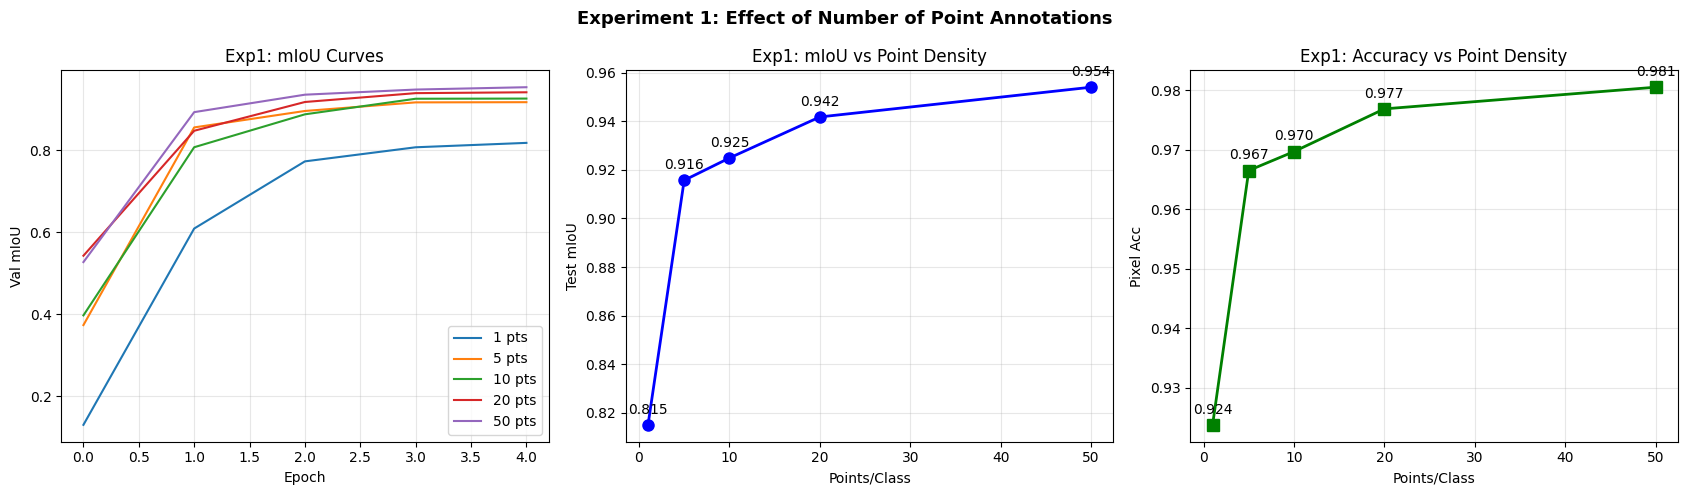


--- Exp 1 Summary ---
Pts/Class   mIoU      Acc
1           0.8151    0.9238
5           0.9157    0.9665
10          0.9248    0.9697
20          0.9417    0.9769
50          0.9540    0.9805


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for k, v in exp1.items():
    axes[0].plot(v['hist']['vm'], label=f'{k} pts')
axes[0].set(xlabel='Epoch', ylabel='Val mIoU', title='Exp1: mIoU Curves')
axes[0].legend(); axes[0].grid(alpha=.3)

ks = sorted(exp1.keys())
ms = [exp1[k]['test_miou'] for k in ks]
acs = [exp1[k]['test_acc'] for k in ks]

axes[1].plot(ks, ms, 'b-o', lw=2, ms=8)
axes[1].set(xlabel='Points/Class', ylabel='Test mIoU', title='Exp1: mIoU vs Point Density')
for x, y in zip(ks, ms):
    axes[1].annotate(f'{y:.3f}', (x,y), xytext=(0,8), textcoords='offset points', ha='center')
axes[1].grid(alpha=.3)

axes[2].plot(ks, acs, 'g-s', lw=2, ms=8)
axes[2].set(xlabel='Points/Class', ylabel='Pixel Acc', title='Exp1: Accuracy vs Point Density')
for x, y in zip(ks, acs):
    axes[2].annotate(f'{y:.3f}', (x,y), xytext=(0,8), textcoords='offset points', ha='center')
axes[2].grid(alpha=.3)

plt.suptitle('Experiment 1: Effect of Number of Point Annotations', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.savefig('exp1.png', dpi=100); plt.show()

print('\n--- Exp 1 Summary ---')
print(f'{"Pts/Class":<12}{"mIoU":<10}{"Acc"}')
for k in ks:
    print(f'{k:<12}{exp1[k]["test_miou"]:<10.4f}{exp1[k]["test_acc"]:.4f}')

In [12]:
# Hypothesis: Stratified sampling provides better spatial coverage,
# helping most when very few points are available
# Process: Compare random vs. stratified at [5, 10, 20] pts/class

exp2 = {'random': {}, 'stratified': {}}

for strat in ['random', 'stratified']:
    for n_pts in [5, 10, 20]:
        tr = RSDataset(200, 128, n_pts, strat, aug=True)
        vl = RSDataset(50, 128, n_pts, strat)
        te = RSDataset(50, 128, n_pts, strat)
        tr_ld = DataLoader(tr, 8, shuffle=True,  num_workers=2)
        vl_ld = DataLoader(vl, 8, num_workers=2)
        te_ld = DataLoader(te, 8, num_workers=2)

        model, hist = train_model(tr_ld, vl_ld, N_EPOCHS,
                                   desc=f'Exp2: {strat}, {n_pts} pts/class')
        _, tm, ta = evaluate(model, te_ld, PartialCrossEntropyLoss())
        exp2[strat][n_pts] = {'hist': hist, 'test_miou': tm, 'test_acc': ta}
        print(f'  [{strat}, pts={n_pts}] mIoU={tm:.4f}\n')

print('Experiment 2 complete!')

Generating 200 samples (pts=5, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 85.86it/s]


Generating 50 samples (pts=5, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 87.76it/s]


Generating 50 samples (pts=5, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 86.38it/s]



Exp2: random, 5 pts/class
Ep[1/5] TrLoss=1.1463 VlLoss=0.8796 mIoU=0.4733 Acc=0.7098
Ep[5/5] TrLoss=0.1082 VlLoss=0.1195 mIoU=0.8886 Acc=0.9568
Best Val mIoU: 0.8886
  [random, pts=5] mIoU=0.8935

Generating 200 samples (pts=10, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 81.05it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 79.05it/s]


Generating 50 samples (pts=10, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 70.90it/s]



Exp2: random, 10 pts/class
Ep[1/5] TrLoss=0.9381 VlLoss=1.1676 mIoU=0.3795 Acc=0.5799
Ep[5/5] TrLoss=0.0783 VlLoss=0.0883 mIoU=0.9279 Acc=0.9705
Best Val mIoU: 0.9279
  [random, pts=10] mIoU=0.9259

Generating 200 samples (pts=20, strategy=random)...


100%|██████████| 200/200 [00:02<00:00, 85.06it/s]


Generating 50 samples (pts=20, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 83.77it/s]


Generating 50 samples (pts=20, strategy=random)...


100%|██████████| 50/50 [00:00<00:00, 86.87it/s]



Exp2: random, 20 pts/class
Ep[1/5] TrLoss=0.9660 VlLoss=1.4812 mIoU=0.3656 Acc=0.5402
Ep[5/5] TrLoss=0.0727 VlLoss=0.0813 mIoU=0.9416 Acc=0.9770
Best Val mIoU: 0.9416
  [random, pts=20] mIoU=0.9390

Generating 200 samples (pts=5, strategy=stratified)...


100%|██████████| 200/200 [00:06<00:00, 29.46it/s]


Generating 50 samples (pts=5, strategy=stratified)...


100%|██████████| 50/50 [00:02<00:00, 19.28it/s]


Generating 50 samples (pts=5, strategy=stratified)...


100%|██████████| 50/50 [00:02<00:00, 24.71it/s]



Exp2: stratified, 5 pts/class
Ep[1/5] TrLoss=1.1824 VlLoss=1.3476 mIoU=0.3069 Acc=0.5043
Ep[5/5] TrLoss=0.1059 VlLoss=0.1108 mIoU=0.9022 Acc=0.9626
Best Val mIoU: 0.9022
  [stratified, pts=5] mIoU=0.9042

Generating 200 samples (pts=10, strategy=stratified)...


100%|██████████| 200/200 [00:07<00:00, 27.80it/s]


Generating 50 samples (pts=10, strategy=stratified)...


100%|██████████| 50/50 [00:02<00:00, 21.37it/s]


Generating 50 samples (pts=10, strategy=stratified)...


100%|██████████| 50/50 [00:02<00:00, 21.00it/s]



Exp2: stratified, 10 pts/class
Ep[1/5] TrLoss=0.8519 VlLoss=0.6685 mIoU=0.5886 Acc=0.7866
Ep[5/5] TrLoss=0.0745 VlLoss=0.0808 mIoU=0.9254 Acc=0.9700
Best Val mIoU: 0.9274
  [stratified, pts=10] mIoU=0.9256

Generating 200 samples (pts=20, strategy=stratified)...


100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


Generating 50 samples (pts=20, strategy=stratified)...


100%|██████████| 50/50 [00:02<00:00, 18.19it/s]


Generating 50 samples (pts=20, strategy=stratified)...


100%|██████████| 50/50 [00:01<00:00, 27.68it/s]



Exp2: stratified, 20 pts/class
Ep[1/5] TrLoss=0.8916 VlLoss=0.9870 mIoU=0.3980 Acc=0.6111
Ep[5/5] TrLoss=0.0824 VlLoss=0.0914 mIoU=0.9250 Acc=0.9705
Best Val mIoU: 0.9250
  [stratified, pts=20] mIoU=0.9249

Experiment 2 complete!


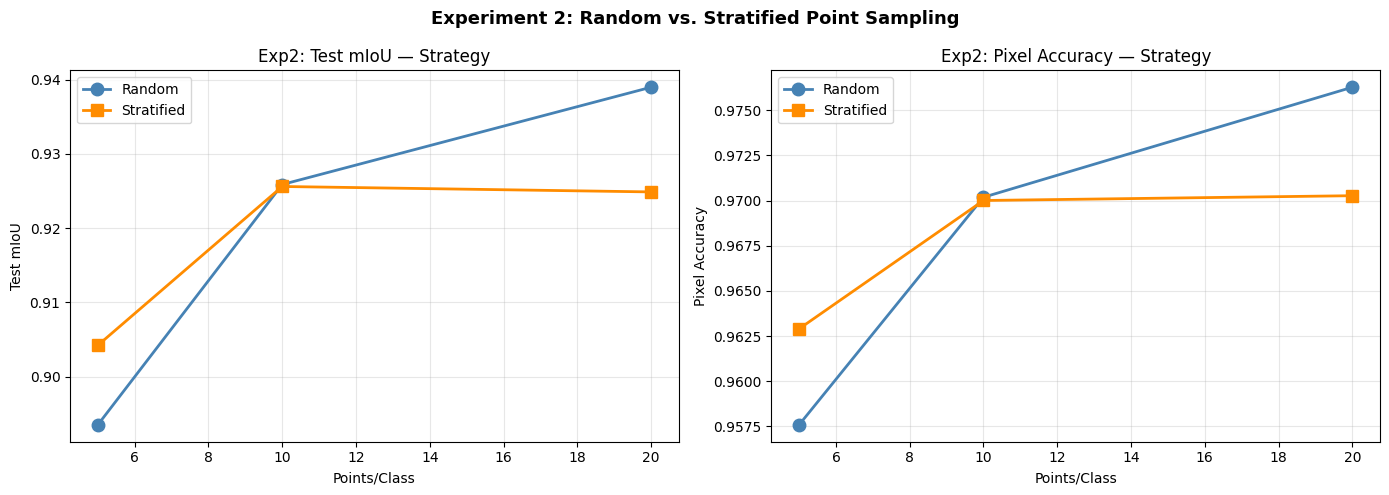


--- Exp 2 Summary ---
Strategy      Pts/Class   mIoU      Acc
random        5           0.8935    0.9576
random        10          0.9259    0.9702
random        20          0.9390    0.9763
stratified    5           0.9042    0.9629
stratified    10          0.9256    0.9700
stratified    20          0.9249    0.9703


In [13]:
cols = {'random': 'steelblue', 'stratified': 'darkorange'}
mks  = {'random': 'o', 'stratified': 's'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for strat in ['random', 'stratified']:
    pts = sorted(exp2[strat].keys())
    ms  = [exp2[strat][p]['test_miou'] for p in pts]
    acs = [exp2[strat][p]['test_acc']  for p in pts]
    axes[0].plot(pts, ms,  color=cols[strat], marker=mks[strat], lw=2, ms=9, label=strat.capitalize())
    axes[1].plot(pts, acs, color=cols[strat], marker=mks[strat], lw=2, ms=9, label=strat.capitalize())

for ax, t in zip(axes, ['Test mIoU', 'Pixel Accuracy']):
    ax.set(xlabel='Points/Class', ylabel=t, title=f'Exp2: {t} — Strategy')
    ax.legend(); ax.grid(alpha=.3)

plt.suptitle('Experiment 2: Random vs. Stratified Point Sampling', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.savefig('exp2.png', dpi=100); plt.show()

print('\n--- Exp 2 Summary ---')
print(f'{"Strategy":<14}{"Pts/Class":<12}{"mIoU":<10}{"Acc"}')
for strat in ['random', 'stratified']:
    for p in sorted(exp2[strat].keys()):
        print(f'{strat:<14}{p:<12}{exp2[strat][p]["test_miou"]:<10.4f}{exp2[strat][p]["test_acc"]:.4f}')


Final: 10 pts/class
Ep[1/5] TrLoss=0.9876 VlLoss=2.2054 mIoU=0.2414 Acc=0.4131
Ep[5/5] TrLoss=0.0852 VlLoss=0.0937 mIoU=0.9258 Acc=0.9702
Best Val mIoU: 0.9258


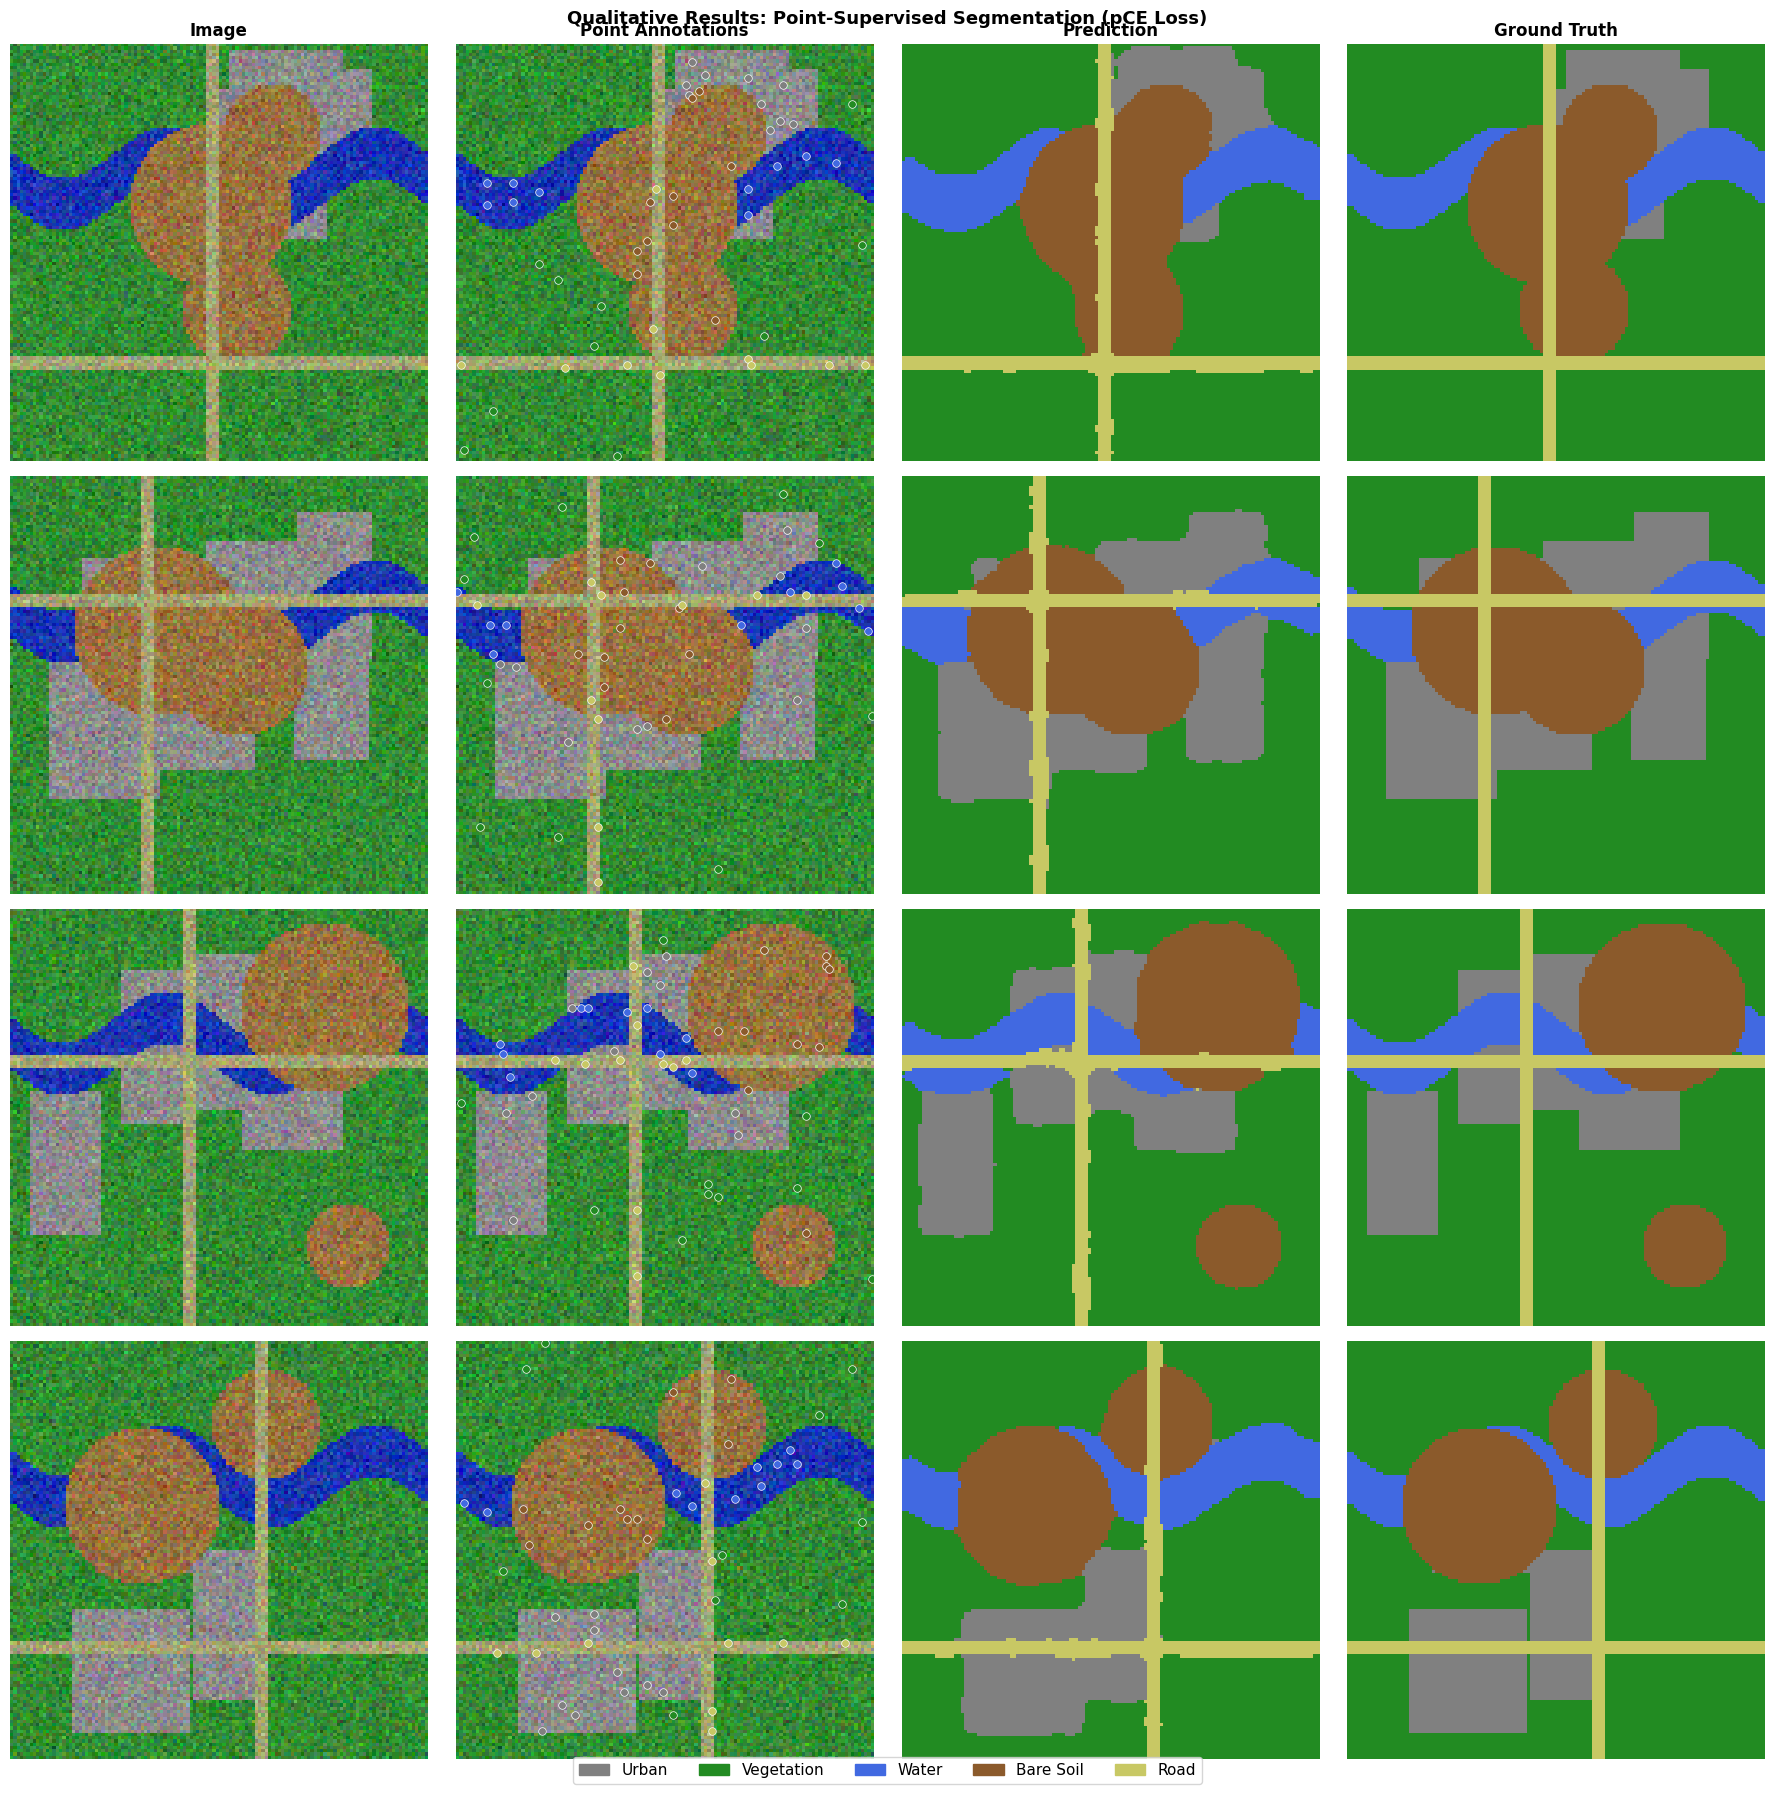

In [14]:
# Train final model for visualization
final_model, _ = train_model(trl, vll, N_EPOCHS, desc='Final: 10 pts/class')

def denorm(t):
    t = t.cpu().clone()
    for c, (m, s) in enumerate(zip([.485,.456,.406], [.229,.224,.225])):
        t[c] = t[c]*s + m
    return t.permute(1,2,0).numpy().clip(0,1)

final_model.eval()
imgs_b, full_b, pts_b = next(iter(tel))
with torch.no_grad():
    preds = final_model(imgs_b.to(DEVICE)).argmax(1).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(18, 18))
for col, title in enumerate(['Image', 'Point Annotations', 'Prediction', 'Ground Truth']):
    axes[0, col].set_title(title, fontsize=12, fontweight='bold')

for i in range(4):
    img_ = denorm(imgs_b[i]); gt_ = full_b[i].numpy()
    pt_  = pts_b[i].numpy();  pr_ = preds[i]

    axes[i,0].imshow(img_); axes[i,0].axis('off')

    axes[i,1].imshow(img_)
    for cls in range(NUM_CLASSES):
        p = np.argwhere(pt_ == cls)
        if len(p):
            axes[i,1].scatter(p[:,1], p[:,0],
                              c=[np.array(CLASS_COLORS[cls])/255],
                              s=30, zorder=5, edgecolors='w', lw=.5)
    axes[i,1].axis('off')

    axes[i,2].imshow(colorize_mask(pr_)); axes[i,2].axis('off')
    axes[i,3].imshow(colorize_mask(gt_)); axes[i,3].axis('off')
    axes[i,0].set_ylabel(f'mIoU={compute_miou(pr_, gt_):.3f}', fontsize=11)

patches = [mpatches.Patch(color=np.array(c)/255, label=n) for c,n in zip(CLASS_COLORS, CLASS_NAMES)]
fig.legend(handles=patches, loc='lower center', ncol=5, fontsize=11, bbox_to_anchor=(.5,-.01))
plt.suptitle('Qualitative Results: Point-Supervised Segmentation (pCE Loss)', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.savefig('qualitative.png', dpi=100); plt.show()

=== Final Test Results ===
Class         IoU      Precision   Recall
----------------------------------------------
Urban         0.9241   0.9453      0.9763
Vegetation    0.9582   0.9976      0.9604
Water         0.9053   0.9168      0.9863
Bare Soil     0.9630   0.9733      0.9890
Road          0.8944   0.9006      0.9923
----------------------------------------------
mIoU          0.9290
Pixel Accuracy: 0.9716


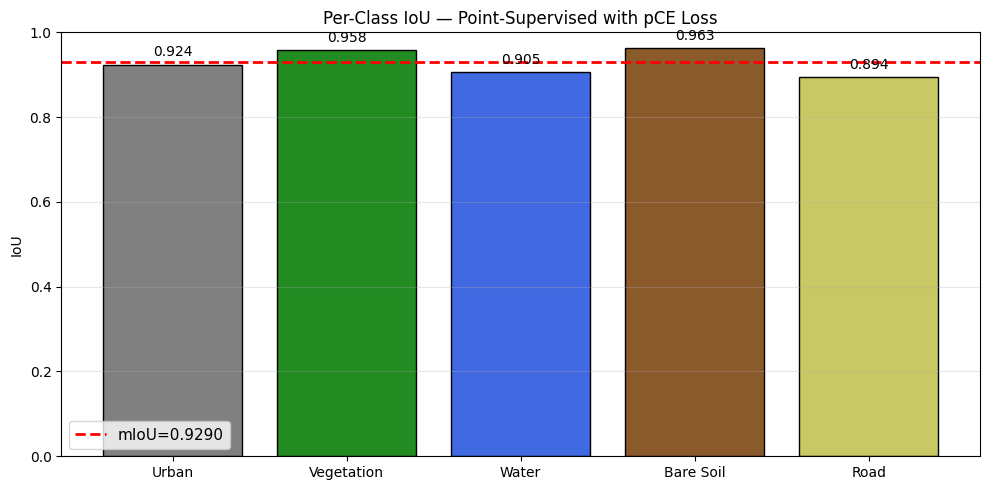


ALL 3 TASKS COMPLETE
Task 1: PartialCrossEntropyLoss → implemented & unit tested
Task 2: U-Net trained on RS data with pCE on point labels
Task 3: Experiment 1 (point density) + Experiment 2 (sampling strategy)


In [15]:
final_model.eval(); ap, at = [], []
with torch.no_grad():
    for imgs, full, _ in tel:
        ap.append(final_model(imgs.to(DEVICE)).argmax(1).cpu().numpy())
        at.append(full.numpy())
ap = np.concatenate(ap).flatten(); at = np.concatenate(at).flatten()

print('=== Final Test Results ===')
print(f'{"Class":<14}{"IoU":<9}{"Precision":<12}{"Recall"}')
print('-'*46)
iou_per = []
for cls in range(NUM_CLASSES):
    pc = (ap==cls); tc = (at==cls)
    inter = (pc&tc).sum(); union = (pc|tc).sum()
    tp = inter; iou = inter/(union+1e-6)
    prec = tp/(pc.sum()+1e-6); rec = tp/(tc.sum()+1e-6)
    iou_per.append(iou)
    print(f'{CLASS_NAMES[cls]:<14}{iou:<9.4f}{prec:<12.4f}{rec:.4f}')

mi = np.mean(iou_per); acc = (ap==at).mean()
print(f'-'*46)
print(f'{"mIoU":<14}{mi:.4f}')
print(f'Pixel Accuracy: {acc:.4f}')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(CLASS_NAMES, iou_per,
              color=[np.array(c)/255 for c in CLASS_COLORS], edgecolor='k')
ax.axhline(mi, color='red', ls='--', lw=2, label=f'mIoU={mi:.4f}')
ax.set(ylabel='IoU', ylim=(0,1), title='Per-Class IoU — Point-Supervised with pCE Loss')
ax.legend(fontsize=11)
for bar, v in zip(bars, iou_per):
    ax.text(bar.get_x()+bar.get_width()/2, v+.02, f'{v:.3f}', ha='center', fontsize=10)
ax.grid(axis='y', alpha=.3); plt.tight_layout()
plt.savefig('per_class_iou.png', dpi=100); plt.show()

print('\n' + '='*60)
print('ALL 3 TASKS COMPLETE')
print('='*60)
print('Task 1: PartialCrossEntropyLoss → implemented & unit tested')
print('Task 2: U-Net trained on RS data with pCE on point labels')
print('Task 3: Experiment 1 (point density) + Experiment 2 (sampling strategy)')